# Compare Gaussian fits across all flights

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site
from astropy.modeling.models import AiryDisk2D

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['Averaged_2dGauss_and_Airy_Param.npz' 'Coadded_2dGauss_With_Errors.npz'
 'Coadded_2dGauss_and_Airy_Params.npz'
 'Coadded_2dGauss_and_Airy_Params_18mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_20mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_25mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_halfspace.npz'
 'FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Air

# FWHM checks

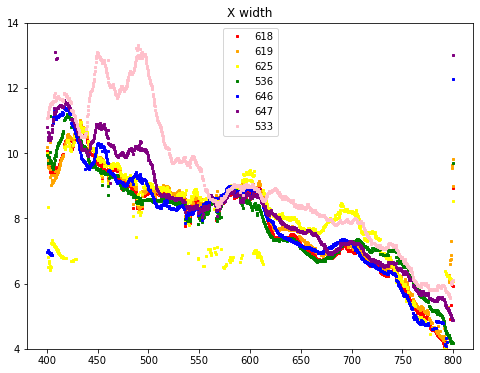

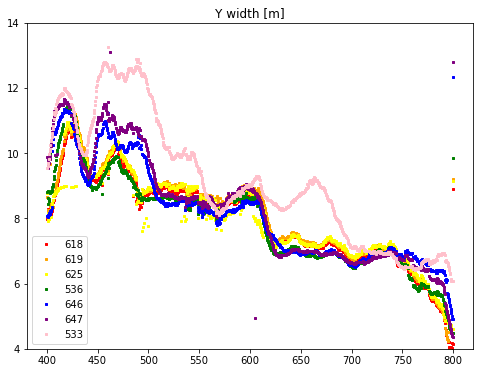

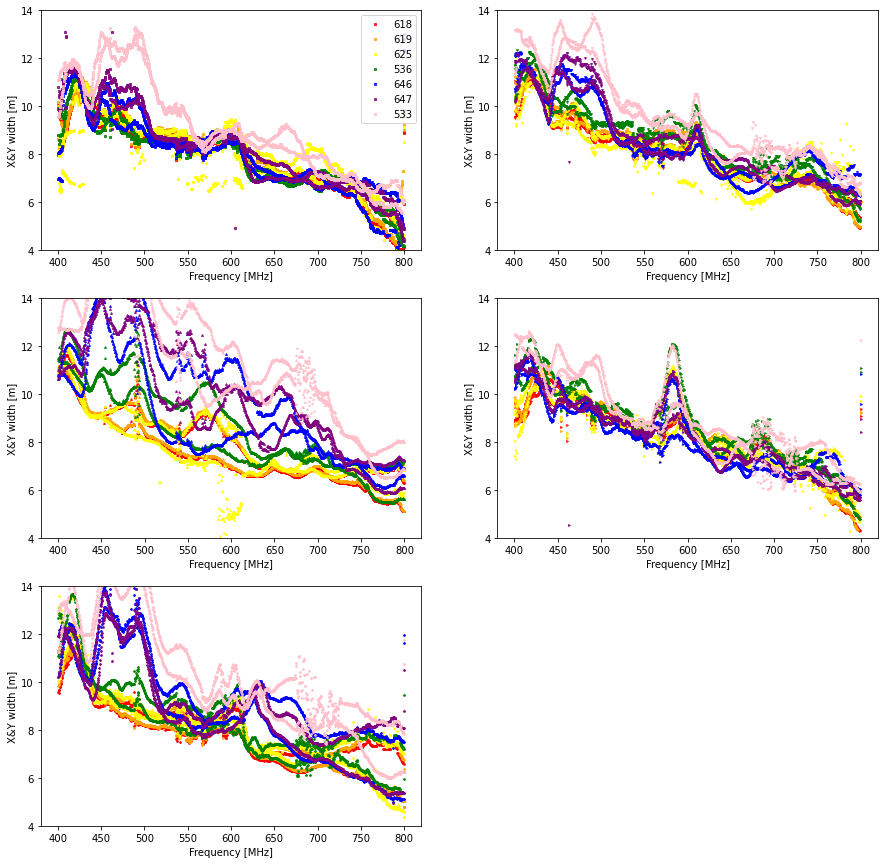

In [4]:
## N pol flights

flies = ['618','619','625','536','646', '647','533']
pols = N_pols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0

# X width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('X width')
plt.legend()
plt.ylim(4,14)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Y width [m]')
plt.legend()
plt.ylim(4,14)
plt.show()

a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()



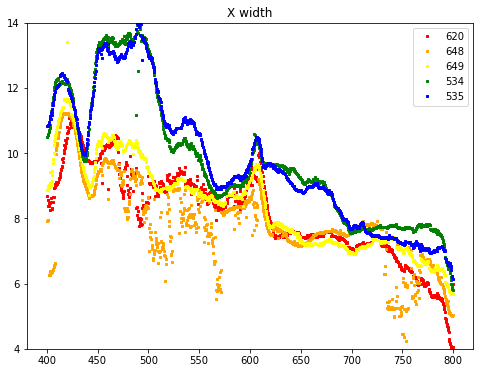

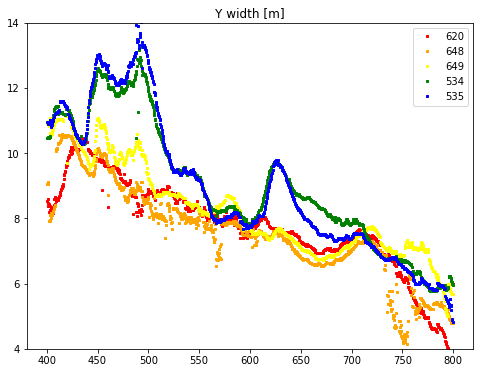

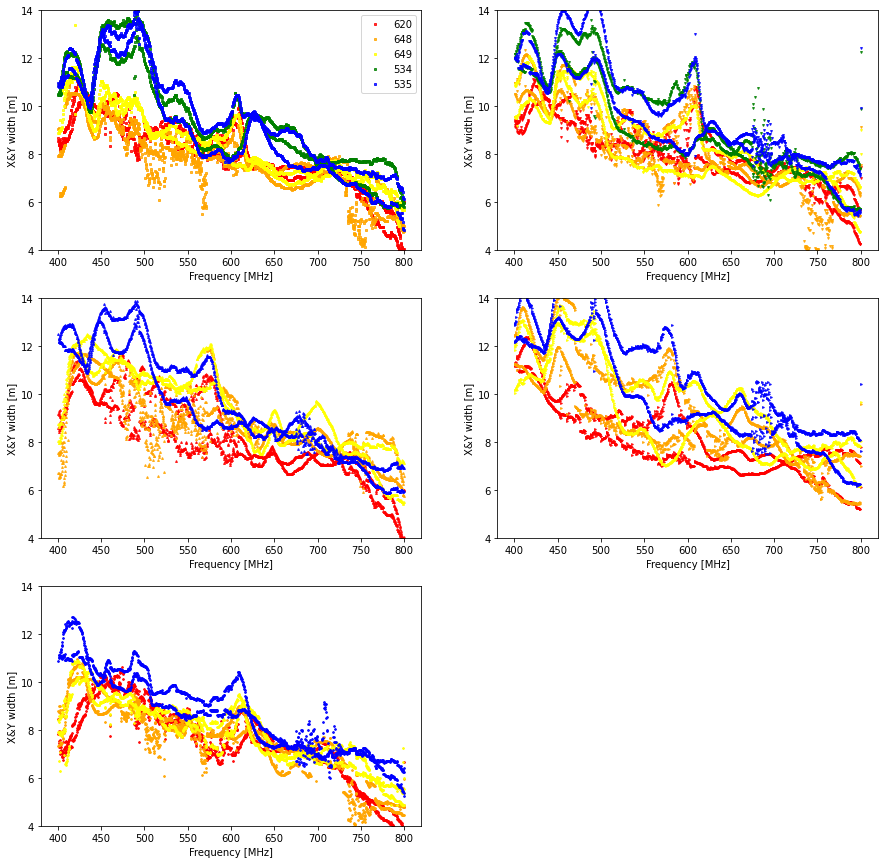

In [5]:
## E pol flights

flies = ['620','648','649','534','535']
pols = E_pols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0

# X width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('X width')
plt.legend()
plt.ylim(4,14)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Y width [m]')
plt.legend()
plt.ylim(4,14)
plt.show()

a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()



In [6]:
# Calculate the mean and std dev for flights I use for the inner main beam:

coadded = np.zeros([16,1024,6,2])

pols = N_pols
flights = ['618','619','625','536']
datastore = np.zeros([16,1024,6,len(flights)])

for f,fly in enumerate(flights):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for j, chind in enumerate(pols): 
        datastore[chind,:,:,f] = fits['G_popt'][chind,:,0:6]
coadded[pols,:,:,0] = np.mean(datastore[pols,:,:],axis=-1)
coadded[pols,:,:,1] = np.std(datastore[pols,:,:],axis=-1)

    




In [37]:
# Load in the coadded values
tmpfitpath='/hirax/GBO_Analysis_Outputs/main_beam_fits/Coadded_2dGauss_and_Airy_Params.npz'
#np.savez(tmpfitpath,G_popt=G_popt)     

# check
comap = np.load(tmpfitpath)




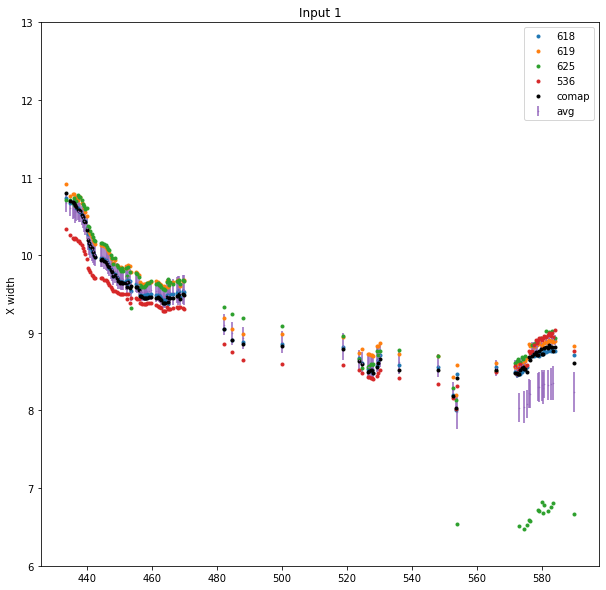

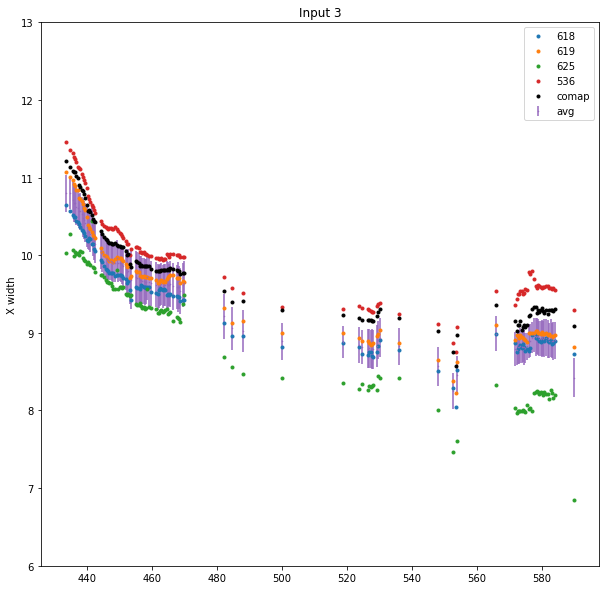

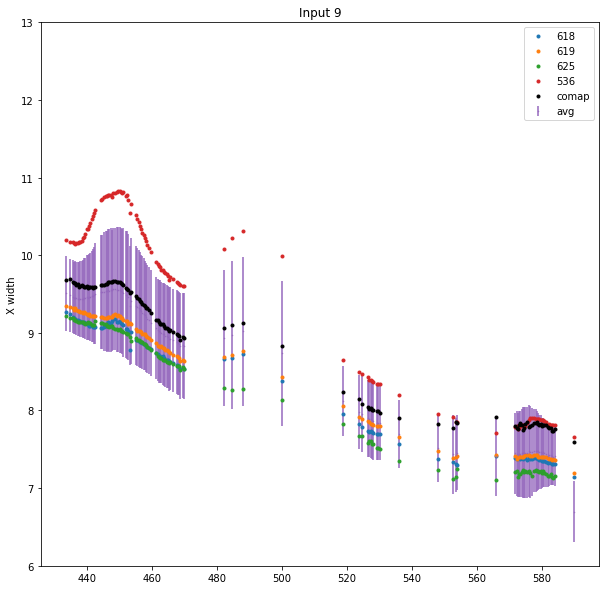

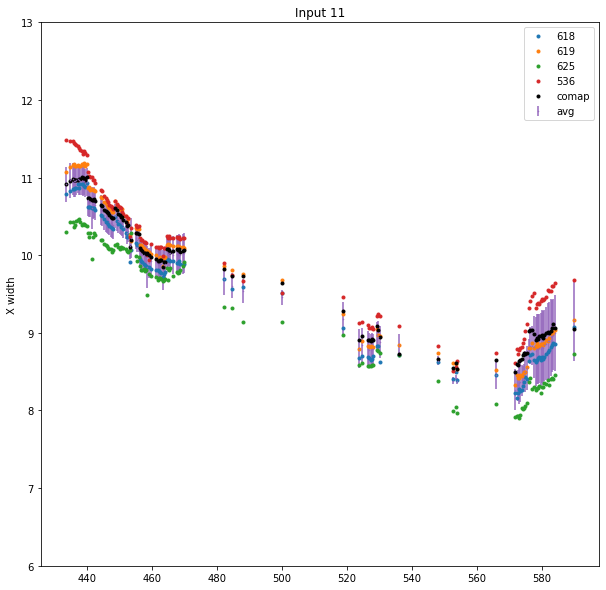

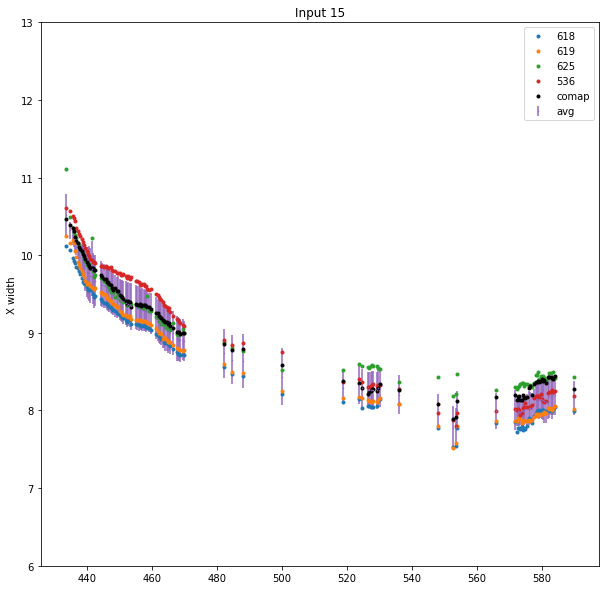

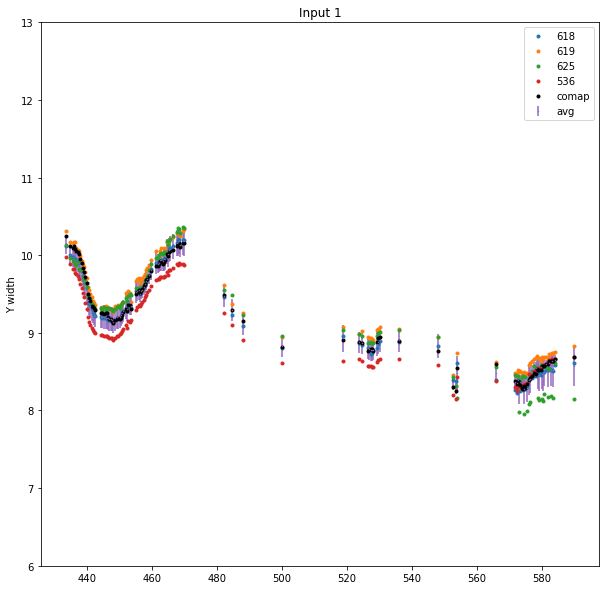

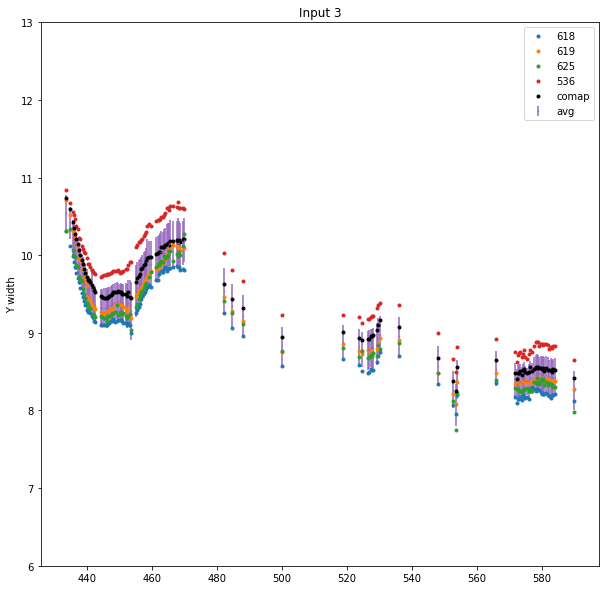

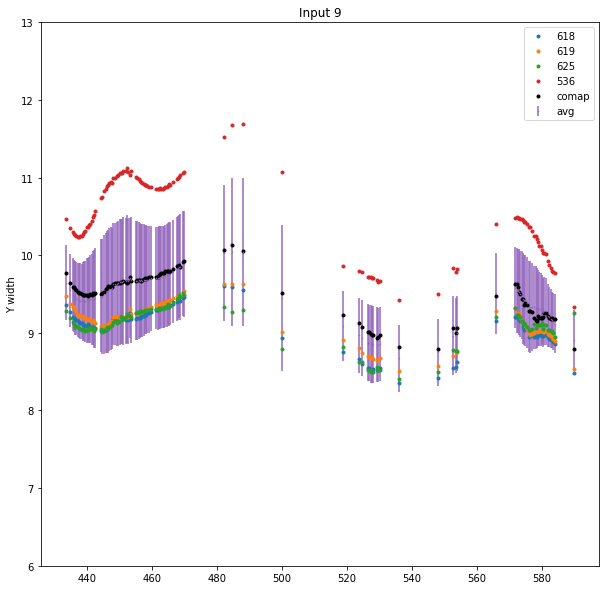

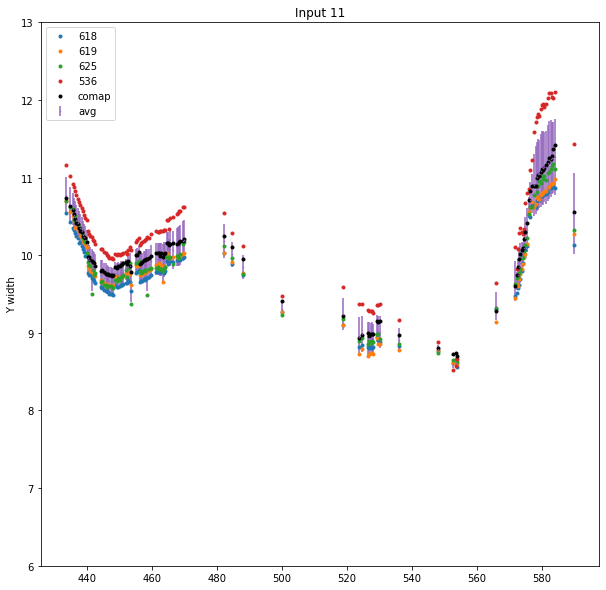

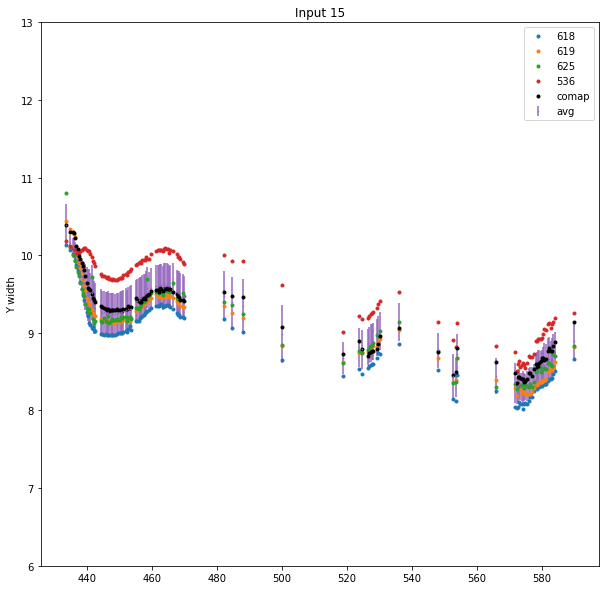

In [40]:

for p in N_pols:
    plt.figure(1,figsize=(10,10))
    plt.title('Input '+str(p))
    for f,fly in enumerate(flights): 
        plt.plot(freqs[good_freqs],datastore[p,good_freqs,2,f],marker='.',linestyle='None',label=str(fly))
    plt.errorbar(freqs[good_freqs],coadded[p,good_freqs,2,0],yerr=coadded[p,good_freqs,4,1],
                 marker='.',markersize=1,linestyle='None',label='avg')
    plt.plot(freqs[good_freqs],comap['G_popt'][p,good_freqs,2],marker='.',color='black',linestyle='None',label='comap')
    plt.legend()
    #plt.xlim(400,600)
    plt.ylim(6,13)
    plt.ylabel('X width')
    plt.show()


for p in N_pols:
    plt.figure(1,figsize=(10,10))
    plt.title('Input '+str(p))
    for f,fly in enumerate(flights): 
        plt.plot(freqs[good_freqs],datastore[p,good_freqs,4,f],marker='.',linestyle='None',label=str(fly))
    plt.errorbar(freqs[good_freqs],coadded[p,good_freqs,4,0],yerr=coadded[p,good_freqs,4,1],
                 marker='.',markersize=1,linestyle='None',label='avg')
    plt.plot(freqs[good_freqs],comap['G_popt'][p,good_freqs,4],marker='.',color='black',linestyle='None',label='comap')
    plt.legend()
    #plt.xlim(400,600)
    plt.ylim(6,13)
    plt.ylabel('Y width')
    plt.show()

In [8]:
for f in good_freqs:
    if datastore[1,f,2,2] < 7: print(f)
print(good_freqs[-1])

538
554
556
558
561
562
563
565
566
572
573
575
577
581
630
938


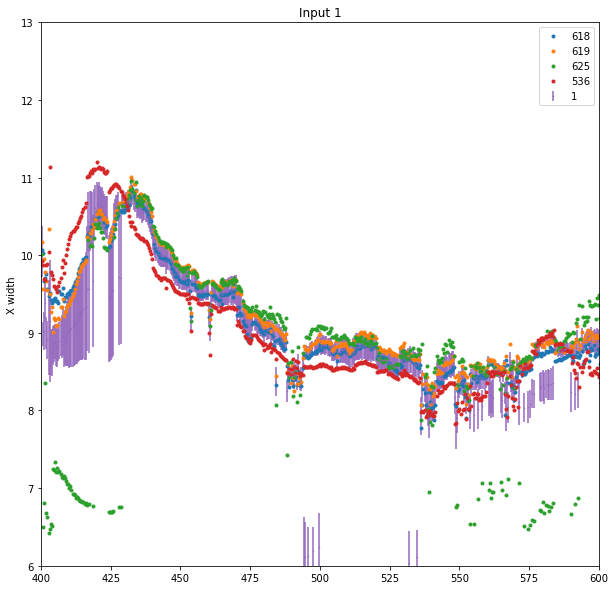

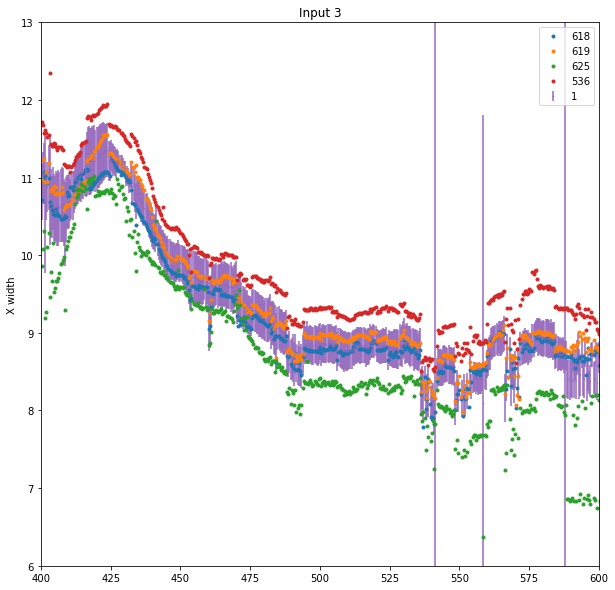

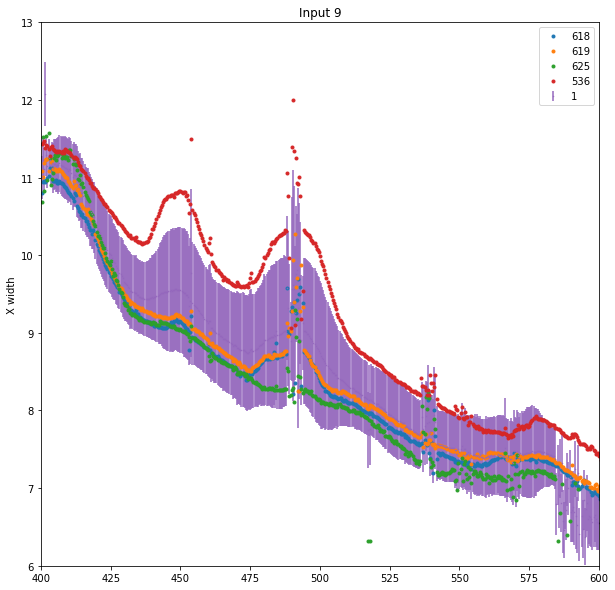

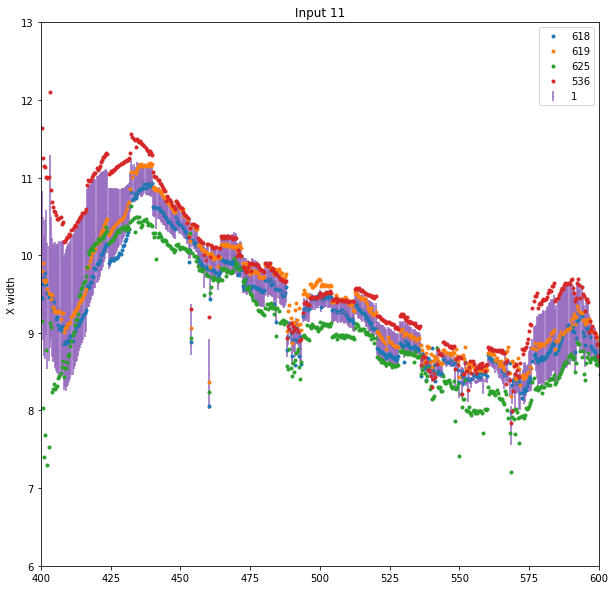

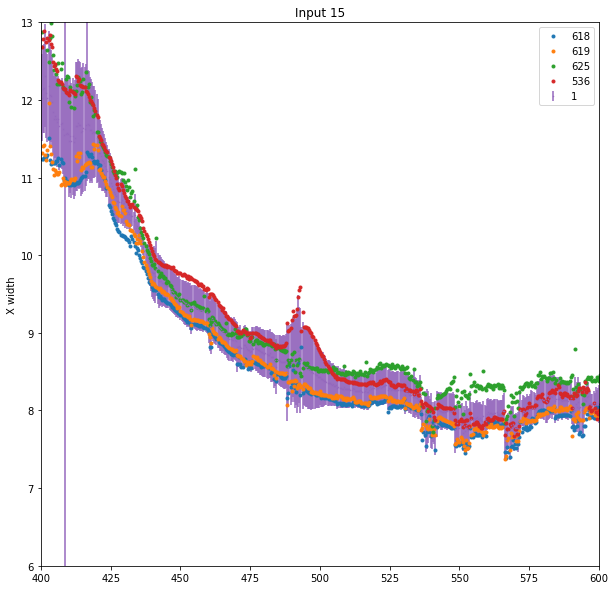

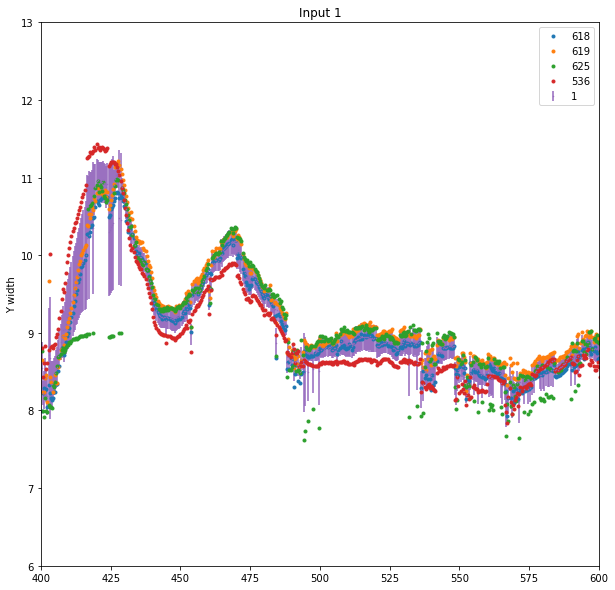

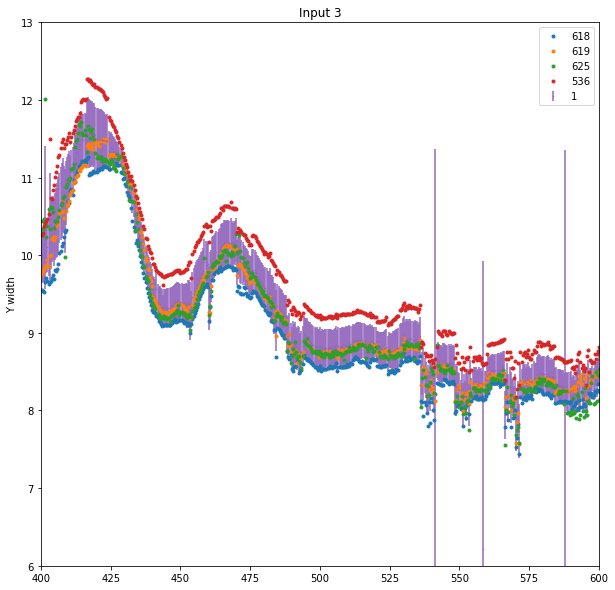

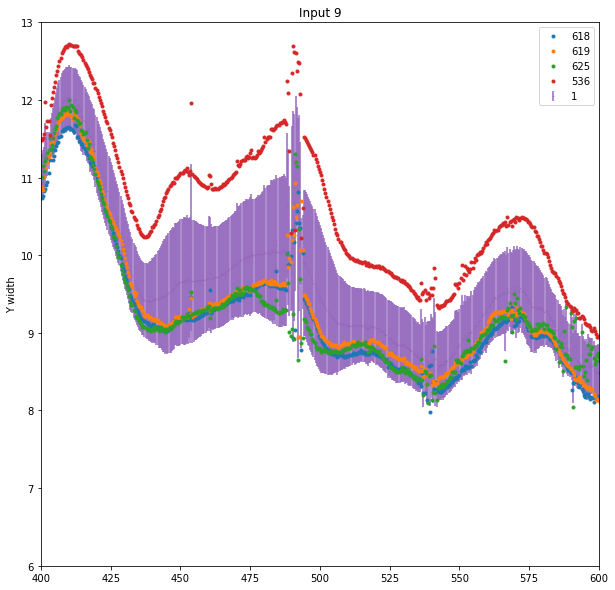

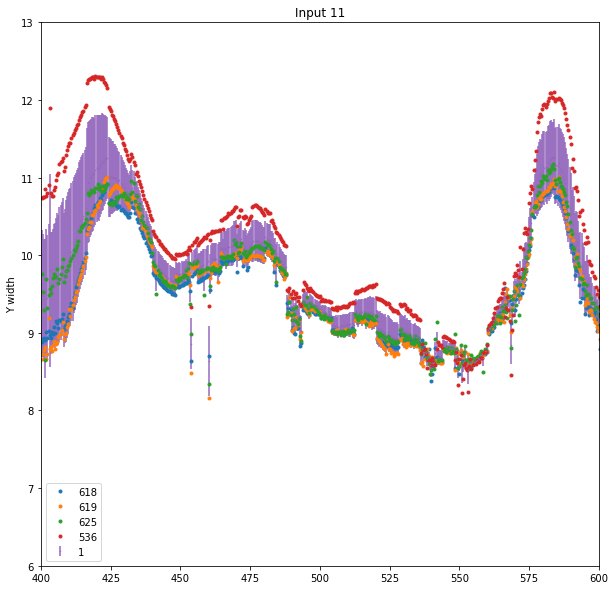

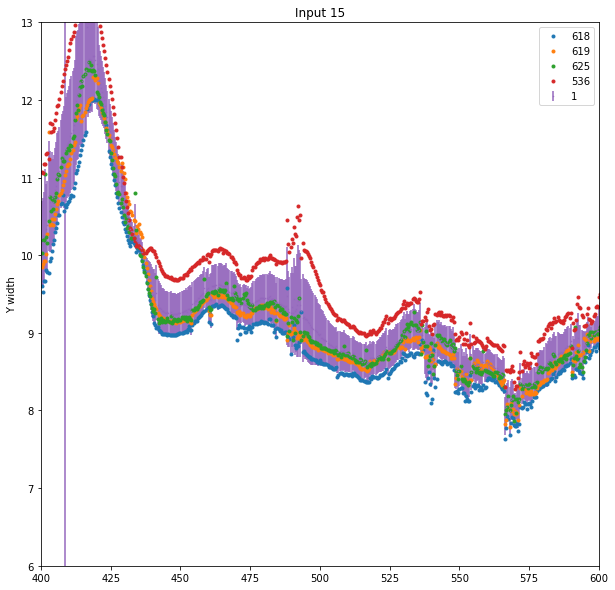

In [33]:

for p in pols:
    plt.figure(1,figsize=(10,10))
    plt.title('Input '+str(p))
    for f,fly in enumerate(flights): 
        plt.plot(freqs,datastore[p,:,2,f],marker='.',linestyle='None',label=str(fly))
    plt.errorbar(freqs,coadded[p,:,2,0],yerr=coadded[p,:,4,1],
                 marker='.',markersize=1,linestyle='None',label=str(chind))
    plt.legend()
    plt.xlim(400,600)
    plt.ylim(6,13)
    plt.ylabel('X width')
    plt.show()


for p in pols:
    plt.figure(1,figsize=(10,10))
    plt.title('Input '+str(p))
    for f,fly in enumerate(flights): 
        plt.plot(freqs,datastore[p,:,4,f],marker='.',linestyle='None',label=str(fly))
    plt.errorbar(freqs,coadded[p,:,4,0],yerr=coadded[p,:,4,1],
                 marker='.',markersize=1,linestyle='None',label=str(chind))
    plt.legend()
    plt.xlim(400,600)
    plt.ylim(6,13)
    plt.ylabel('Y width')
    plt.show()

433.59375
618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
1
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl']
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl'>
[ 1.49067610e-08 -2.87144684e+00  1.07414230e+01  1.88210847e+00
  1.01205529e+01  2.61076776e-10  0.00000000e+00]


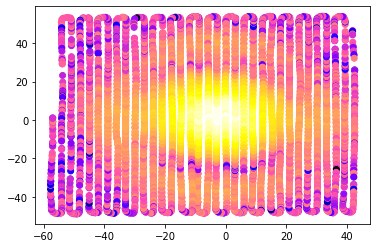

In [10]:
# Now let's try to look at a slice through the beam with a fit, pick a 'good' frequency first
find = 938
print(freqs[find])

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here
chind = pols[0]
print(chind)

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)



with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on 

print(concattest1.G_popt[chind,find,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[chind,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[chind,t_cut,1]
z = concattest1.V_bgsub[t_cut,find,chind]

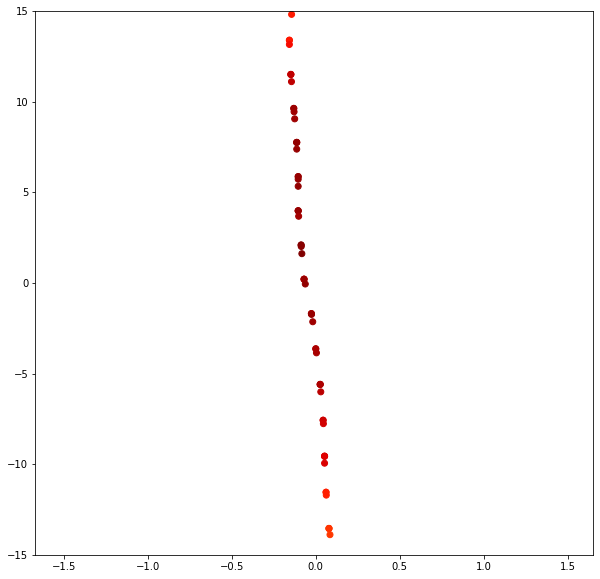

In [11]:
def get_slice_xy(xes,yes,zes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

pp = get_slice_xy(x,y,z,0.0,'x')

plt.figure(1,figsize=(10,10))
plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
plt.ylim(-15,15)
#plt.xlim(5.35,5.48)
plt.show()

[ 1.49471207e-08 -2.87230572e+00  1.07687897e+01  1.87573317e+00
  1.01817880e+01  2.18636927e-10]


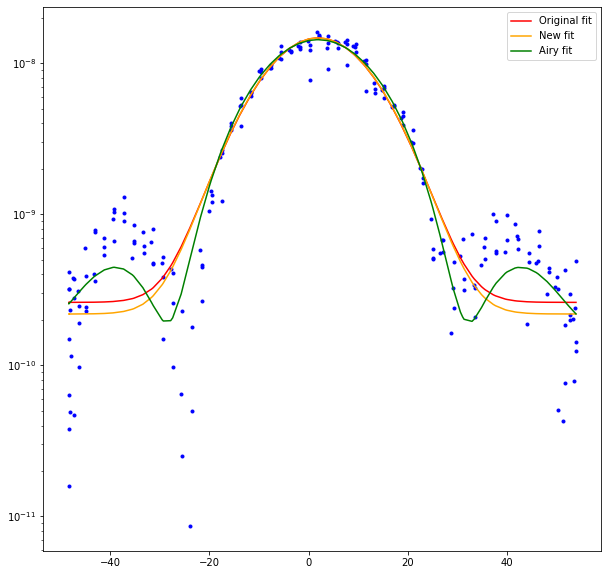

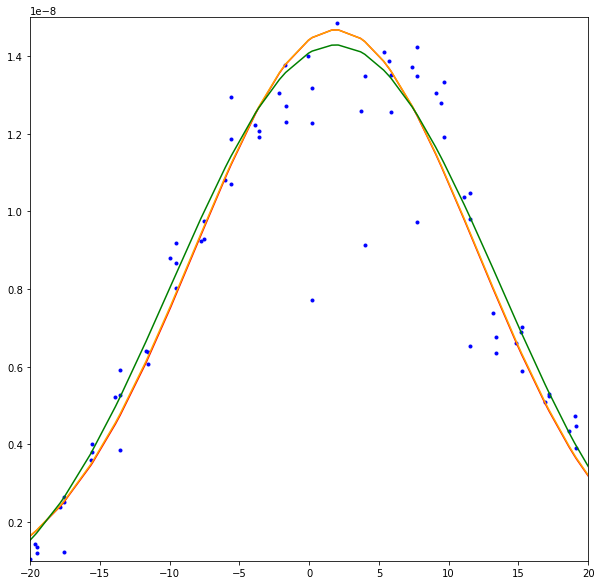

In [12]:
## Let's try re-fitting and playing around

def Gauss_2d_LC_opt(P,x,y,V):
    Gauss_eval = Gauss_2d_LC_func(P,x,y)
    return Gauss_eval-V

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    xx = ((x-x0)**2)/(2*(xsig**2))
    yy = ((y-y0)**2)/(2*(ysig**2))
    return amp*np.exp(-1.0*(xx + yy))+c

def Airy_2d_LC_opt(P,x,y,V):
    AD=AiryDisk2D(1,5,5,radius=1)
    amp,x0,y0,rad,c=P
    return AD.evaluate(x,y,amp,x0,y0,rad)+c-V

def Airy_2d_LC_func(P,x,y):
    AD=AiryDisk2D(1,5,5,radius=1)
    amp,x0,y0,rad,c=P
    return AD.evaluate(x,y,amp,x0,y0,rad)+c


coordbounds = 70.0
ampbound = 0.999
ttcut=np.where((np.abs(x) < coordbounds) 
                  & (np.abs(y)<coordbounds) 
                  & (z <ampbound*(np.nanmax(z))))[0]
                   

#ttcut = np.where((np.isfinite(x)) & (np.isfinite(y)) & (np.isfinite(z)))[0]
mbx=x[ttcut]
mby=y[ttcut]
mbz=z[ttcut]
input_data=np.array([mbx,mby,mbz])

# Form the original fit from the Gpopt
fitz = fu.Gauss_2d_LC_func(concattest1.G_popt[chind,find,0:6],x[pp],y[pp])


## Refit
amp0 = np.nanmax(mbz)#1E-8
x00 = 0.0
y00 = 0.0
xsig0 = 9.0
ysig0 = 9.0
bg0 = np.nanmin(mbz)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
newfit=least_squares(Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
print(newfit)
fit_a = Gauss_2d_LC_func(newfit,x[pp],y[pp])

airy = least_squares(Airy_2d_LC_opt,x0=[amp0,x00,y00,xsig0,bg0],method='trf',args=input_data).x
fit_airy = Airy_2d_LC_func(airy,x[pp],y[pp])

plt.figure(1,figsize=(10,10))
plt.semilogy(y[pp],z[pp],'b.')
plt.semilogy(y[pp],fitz,color='red',label='Original fit')
plt.semilogy(y[pp],fit_a,color='orange',label='New fit')
plt.semilogy(y[pp],fit_airy,color='green',label='Airy fit')
plt.legend()
plt.show()

plt.figure(1,figsize=(10,10))
plt.plot(y[pp],z[pp],'b.')
plt.plot(y[pp],fitz,color='red')
plt.plot(y[pp],fit_a,color='orange')
plt.plot(y[pp],fit_airy,color='green')
plt.xlim(-20,20)
plt.ylim(1E-9,1.5E-8)
plt.show()

536 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 43
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl']
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl'>
[ 3.00345555e-08 -4.53736912e+00  1.03428017e+01  2.91453827e+00
  9.97853874e+00  6.22186649e-10  0.00000000e+00]


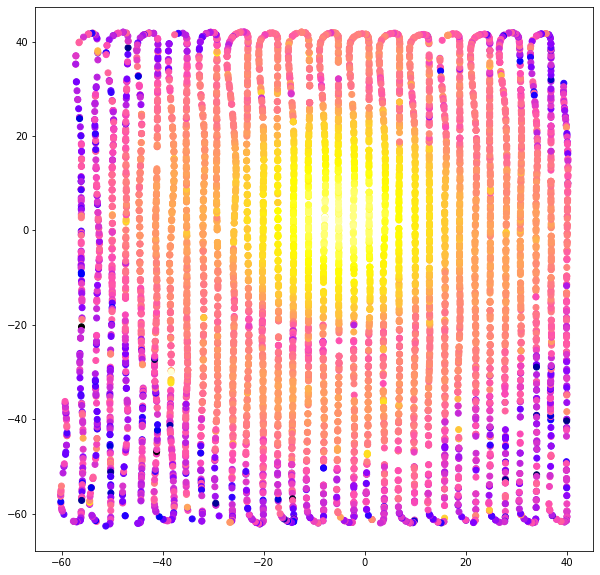

In [13]:
# Now let's try to look at a slice through the beam with a fit, pick a 'good' frequency first

fly = '536'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on    

print(concattest1.G_popt[chind,find,:])

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(concattest1.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[chind,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[chind,t_cut,1]
z = concattest1.V_bgsub[t_cut,find,chind]


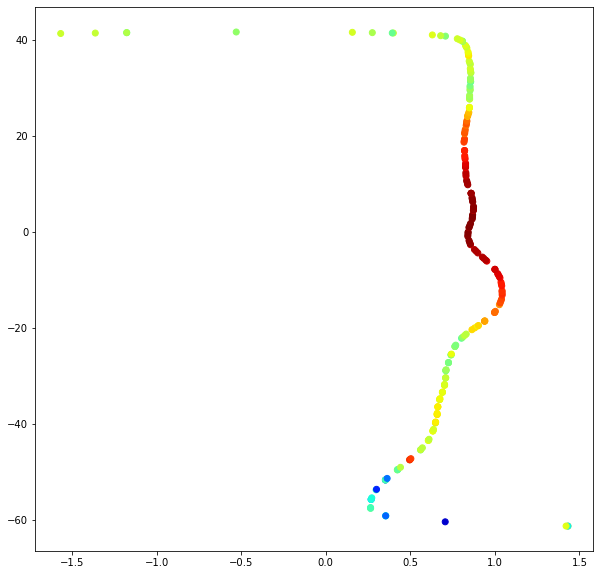

In [14]:
def get_slice_xy(xes,yes,zes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

pp = get_slice_xy(x,y,z,0.0,'x')

plt.figure(1,figsize=(10,10))
plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
#plt.ylim(-15,15)
#plt.xlim(5.35,5.48)
plt.show()

[ 3.00420580e-08 -4.53708256e+00  1.04638222e+01  2.91389826e+00
  1.00911044e+01  4.49057577e-10]
[ 2.89785682e-08 -4.54524629e+00  2.91621494e+00  3.02152764e+01
  3.79582038e-10]


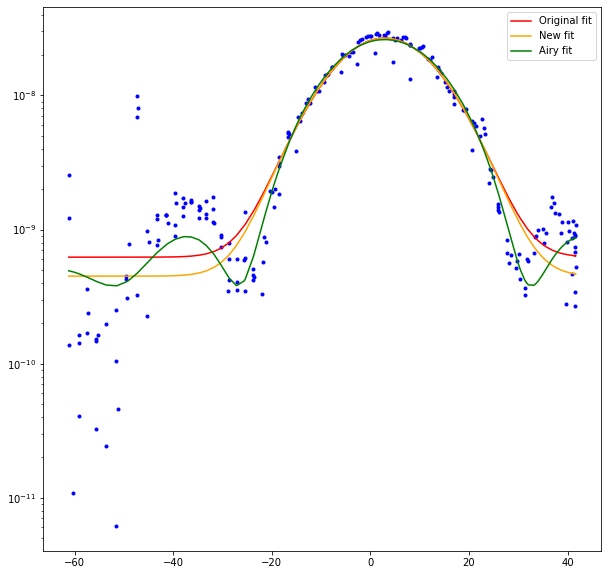

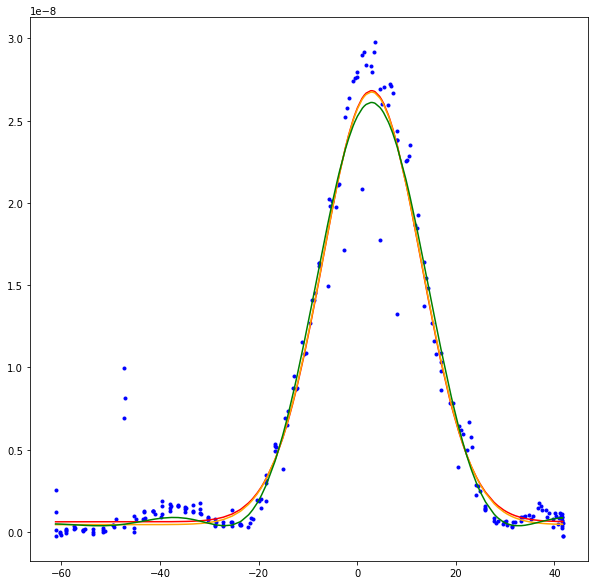

In [28]:
## Let's try re-fitting and playing around

coordbounds = 70.0
ampbound = 0.999
ttcut=np.where((np.abs(x) < coordbounds) 
                  & (np.abs(y)<coordbounds) 
                  & (z <ampbound*(np.nanmax(z))))[0]
                   

#ttcut = np.where((np.isfinite(x)) & (np.isfinite(y)) & (np.isfinite(z)))[0]
mbx=x[ttcut]
mby=y[ttcut]
mbz=z[ttcut]
input_data=np.array([mbx,mby,mbz])

# Form the original fit from the Gpopt
fitz = fu.Gauss_2d_LC_func(concattest1.G_popt[chind,find,0:6],x[pp],y[pp])


## Refit
amp0 = np.nanmax(mbz)#1E-8
x00 = 0.0
y00 = 0.0
xsig0 = 30.0
ysig0 = 30.0
bg0 = np.nanmin(mbz)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
newfit=least_squares(Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
print(newfit)
fit_a = Gauss_2d_LC_func(newfit,x[pp],y[pp])

airy = least_squares(Airy_2d_LC_opt,x0=[amp0,x00,y00,xsig0,bg0],method='trf',args=input_data).x
fit_airy = Airy_2d_LC_func(airy,x[pp],y[pp])
print(airy)

plt.figure(1,figsize=(10,10))
plt.semilogy(y[pp],z[pp],'b.')
plt.semilogy(y[pp],fitz,color='red',label='Original fit')
plt.semilogy(y[pp],fit_a,color='orange',label='New fit')
plt.semilogy(y[pp],fit_airy,color='green',label='Airy fit')
plt.legend()
plt.show()

plt.figure(1,figsize=(10,10))
plt.plot(y[pp],z[pp],'b.')
plt.plot(y[pp],fitz,color='red')
plt.plot(y[pp],fit_a,color='orange')
plt.plot(y[pp],fit_airy,color='green')
#plt.xlim(-20,20)
#plt.ylim(1E-9,1.5E-8)
plt.show()

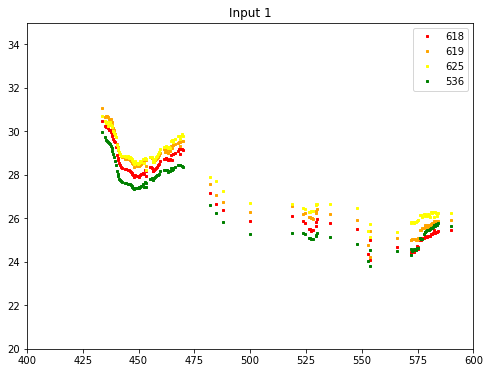

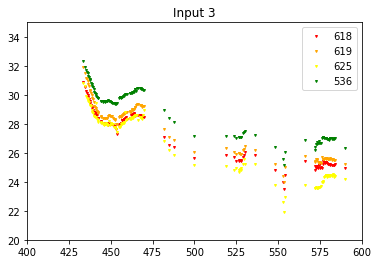

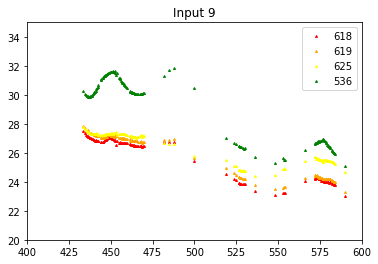

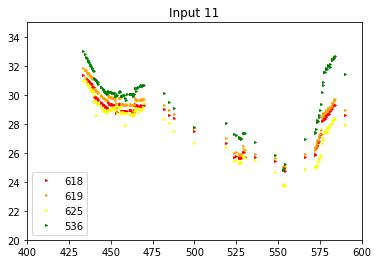

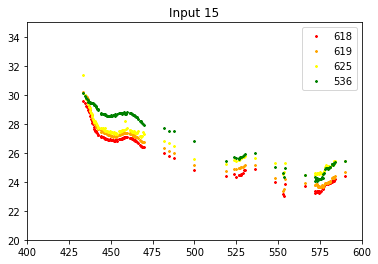

In [36]:
# Did we save the Airy fits in the main beam fitting?
pols = N_pols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0
flies = flights = ['618','619','625','536']

# X width
fig = plt.figure(figsize=(8,6))
for p,pol in enumerate(pols):
    for f,fly in enumerate(flies):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
    
        plt.plot(freqs[good_freqs],fits['A_popt'][pol,good_freqs,3],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
    plt.title('X width')
    plt.legend()
    plt.xlim(400,600)
    plt.ylim(20,35)
    plt.title('Input '+str(pol))
    plt.show()


(16, 1024, 5)

# Amplitude checks

In [ ]:
sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = glob.glob(sdire+'*'+'dish'+'*')
fig = plt.figure(figsize=(10,6))
for ms in mess:
    dat = np.loadtxt(ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
#plt.legend()
plt.show()

In [ ]:
##################################################
############# Spec an measurements ###############
##################################################

# There were some wierdnesses, check first spectra from the Oct flights

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = glob.glob(sdire+'*'+'ns'+'*')
fig = plt.figure(figsize=(10,6))
for ms in mess:
    dat = np.loadtxt(ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
#plt.legend()
plt.show()

# Here I'm trying to match them to the flights

# 46dB attenuated flights
sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-013.csv','ns-014.csv','ns-015.csv','ns-016.csv','ns-017.csv','ns-018.csv','ns-019.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('46dB atten level: flights 618, 619, 620, 623')
plt.show()

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-019.csv','ns-020.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('36dB atten level: flight 625  -- may have changed attenuation after')
plt.show()

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-027.csv','ns-028.csv','ns-029.csv']
fig = plt.figure(figsize=(8,6))
for ms in mess:
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))

    plt.plot(dat[:,0]/1E6,dat[:,1],label=ms)
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [dBm]')
plt.title('30dB atten level: flights 646,647,648,649')
plt.show()



In [ ]:
## North-polarized flights:

flies = ['618','619','623','625','536','646','647','533']
attn = ['-NS-46', '-EW-46','-NS-46','-NS-46','-NS-43','-NS-40','-EW-40','-EW-36']
pols = Npols
markers = ['s','v','^','>','P','x','+','o']

for p in range(0,len(pols)):

    fig = plt.figure(figsize=(8,6))

    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][pols[p],:,0],marker='.',markersize=1,linestyle='None',label=fly+attn[f])
    plt.title('INPUT: '+str(pols[p]))
    plt.ylim(0,4E-7)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('Amplitude [arb]')
    plt.legend(markerscale=10)
    plt.show()


In [ ]:
## East-polarized flights:

flies = ['620','648','649','534','535']
attn = ['-NS-46','-NS-40','-EW-40','-NS-36','-EW-36']
pols = Epols
markers = ['s','v','^','>','P','x','+','o']

for p in range(0,len(pols)):

    fig = plt.figure(figsize=(8,6))

    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0],marker='.',markersize=1,linestyle='None',label=fly+attn[f])
        except:''
    plt.title('Input: '+str(pols[p]))
    plt.ylim(0,4E-7)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('Amplitude [arb]')
    plt.legend(markerscale=10)
    plt.show()

In [ ]:
## Compare to expected ratios --- N pol flights:

flies = ['619','623','625','646','647']
exprat = [1.0, 1.0, 1.0, 4.5, 4.5] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

# check the ratio for the later flights:
specans = ['ns-016.csv','ns-018.csv','ns-019.csv','ns-028.csv','ns-029.csv']
dat618 = np.loadtxt(sdire+'ns-015.csv',skiprows=100,delimiter=',',usecols=(0,1))
    


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    print(ffile)
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
    dat = np.loadtxt(sdire+specans[f],skiprows=100,delimiter=',',usecols=(0,1))
    plt.plot(dat[:,0]/1E6,10**(dat[:,1]/10.) / 10**(dat618[:,1]/10.),color='black',linewidth=5)
plt.title('Amplitudes relative to flight 618')
plt.legend(ncol=5)
plt.ylim(0,10)
plt.show()

In [ ]:
## Compare to expected ratios --- N pol flights:

flies = ['619','623','625','536','646','647','533']
exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink','grey']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(420+ (30*f), 9, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618')
#plt.legend()
plt.ylim(0,10)
plt.show()


fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
    plt.text(420+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
## Compare to expected ratios ---- E pol flights:

flies = flies = ['535','534','648','649']
exprat = [10.0, 10.0, 4.5, 4.5]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(550+ (30*f), 9, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618')
plt.ylim(0,10)
plt.show()

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(420+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0,1.2)
plt.show()



In [ ]:
# Try to combine...

## Npols
flies = ['619','623','625','536','646','647','533']
exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 618 or 620 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
## Since the 500 flights are outliers, try to use one of those as a calibrator.
# Statistics are low, but helpful to see

## Npols
flies = ['533']
exprat = [5.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['blue']

fly = '536'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0]),marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['535']
exprat = [1.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['royalblue']

fly = '534'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0]),marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 536 or 534 / expected ratio')
#plt.legend()
plt.ylim(0,5.0)
plt.show()


##### Compare with expected ratios #####

## Npols
flies = ['533']
exprat = [5.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['blue']

fly = '536'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')

## Epols
flies = ['535']
exprat = [1.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['royalblue']

fly = '534'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
        except:''
    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to 536 or 534 / expected ratio')
#plt.legend()
plt.ylim(0,1.2)
plt.show()

In [ ]:
### ATTEMPT TO CORRECT FOR THE AMPLITUDES
# First use the variance values, this is true for only dish 0, one frequency
rattN = [1.0, 1.0, 1.0, 0.86, 0.92, 1.0, 1.78]

## Npols
flies = ['619','623','625','536','646','647','533']

exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,1):#len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.6, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0.5,1.5)
plt.xlim(400,600)

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

#for f in range(0,len(flies)):
#    fly = flies[f]
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
#    fits = np.load(ffile)
#    for p in range(0,len(pols)):
#        try:
#            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
#        except:''
#    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
#plt.title('Amplitudes relative to 618 or 620 / expected ratio')
##plt.legend()
#plt.ylim(0,1.2)
#plt.show()

In [ ]:
### ATTEMPT TO CORRECT FOR THE AMPLITUDES
# First use the variance values, this is true for only dish 0, one frequency
rattN = [1.0, 1.0, 1.0, 0.86, 0.92, 1.0, 1.78]

## Npols
flies = ['619','623','625','536','646','647','533']

exprat = [1.0, 1.0, 1.0, 2.0, 4.5, 4.5, 10.0] #using ratio from spec an measurement
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','grey','purple','pink','blue']

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,1):#len(pols)):
        plt.plot(freqs,(fits['G_popt'][pols[p],:,0]*rattN[f]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
    plt.text(390+ (30*f), 0.6, flies[f], color=colors[f],fontsize=16)
plt.title('Amplitudes relative to flight 618 / expected ratio')
plt.ylim(0.5,1.5)
plt.xlim(400,600)

## Epols
flies = ['648','649','535','534']
exprat = [4.5, 4.5, 10.0, 10.0]
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['violet','magenta','royalblue','dodgerblue']

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits0 = np.load(ffile)

#for f in range(0,len(flies)):
#    fly = flies[f]
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
#    fits = np.load(ffile)
#    for p in range(0,len(pols)):
#        try:
#            plt.plot(freqs,(fits['G_popt'][pols[p],:,0]/fits0['G_popt'][pols[p],:,0])/exprat[f],marker='.',markersize=1,color=colors[f],linestyle='None',label=fly)
#        except:''
#    plt.text(620+ (30*f), 0.05, flies[f], color=colors[f],fontsize=16)
#plt.title('Amplitudes relative to 618 or 620 / expected ratio')
##plt.legend()
#plt.ylim(0,1.2)
#plt.show()

# Timing offsets

In [ ]:
ymlfiles = os.listdir(ymldir)
flytags = []
toffs = []
for ymlfile in ymlfiles:
    with open(ymldir+ymlfile, 'r') as fff:
        documents = yaml.safe_load(fff)
        print(documents["file_info"]["FLYTAG"],documents["timing_params"]["t_delta_dji"])
        flytags.append(documents["file_info"]["FLYTAG"])
        toffs.append(documents["timing_params"]["t_delta_dji"])
labels = flytags
x = np.arange(0,len(toffs))
# Plot both separately

plt.plot(toffs,'k.')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Timing offset (s)')
plt.show()

# Offsets

In [ ]:
## N pol flights:

flies = ['618','619','623','625','646','647']
pols = Npols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(freqs,fits['G_popt'][pols[p],:,5],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Offsets')
plt.legend()
plt.ylim(0,2E-9)
plt.show()

In [ ]:
# E pol flights
flies = ['620','648','649','534','535']
pols = Epols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','green','blue','purple','pink']

fig = plt.figure(figsize=(10,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(freqs,fits['G_popt'][pols[p],:,5],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
        except:''
plt.title('Offsets')
plt.legend()
plt.ylim(0,2E-9)
for i in range(0,5):
    plt.axvline(440 + 63*i,color='black',lw=3)

plt.show()

In [ ]:
print(3E8/63E6)

fD = 0.398 # from pranav
6*(fD)*2

In [ ]:
markers = ['s','v','^','>','P','x','+','o']
cmap = cm.get_cmap('Spectral')
## North-polarized flights:

flies = ['618','533','619','647','536','618','623','625']
pols = Npols

fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    print(f, flies[f],fly)
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],
                 marker=markers[p],color=cmap(f/13),linestyle='None',label=fly)
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()

# Centroid locations

In [ ]:
markers = ['s','v','^','>','P','x','+','o']
cmap = cm.get_cmap('Spectral')
## North-polarized flights:

flies = ['618','533','619','647','536','618','623','625']
pols = Npols

fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],
                 marker=markers[p],color=cmap(f/13),linestyle='None',label=fly)
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()


## East-polarized flights:

flies = ['535','534','649','620','648']
pols = Epols


fig = plt.figure(figsize=(8,8))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            plt.plot(fits['G_popt'][pols[p],freq_i,1],fits['G_popt'][pols[p],freq_i,3],color=cmap((f+7)/13),marker=markers[p],linestyle='None',label=fly)
        except:''
plt.xlabel('X centroid [m]')
plt.ylabel('Y centroid [m]')
plt.show()

## ## Combine the two together, take a median over all frequencies, make plot above look nice ## ##

cms = np.zeros([13,len(pols),2]) # flight, pol (0-7), X,Y

flies = ['533','536','618','619','623','625','646','647']
pols = Npols
F = len(flies)

for f in range(0,len(flies)):
    ffile = glob.glob(fitdir+'*'+flies[f]+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        #cms[f,p,0] = np.nanmedian(fits['G_popt'][pols[p],:,1])
        #cms[f,p,1] = np.nanmedian(fits['G_popt'][pols[p],:,3])
        cms[f,p,0] = np.nanmedian(fits['G_popt'][pols[p],650:-1,1]) # less than 550 MHz
        cms[f,p,1] = np.nanmedian(fits['G_popt'][pols[p],650:-1,3]) # less than 550 MHz
        
flies = ['534','535','620','648','649']
pols = Epols

for f in range(0,len(flies)):
    ffile = glob.glob(fitdir+'*'+flies[f]+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            #cms[f+F-1,p,0] = np.nanmedian(fits['G_popt'][pols[p],:,1])
            #cms[f+F-1,p,1] = np.nanmedian(fits['G_popt'][pols[p],:,3])
            cms[f+F-1,p,0] = np.nanmedian(fits['G_popt'][pols[p],650:-1,1]) # less than 550 MHz
            cms[f+F-1,p,1] = np.nanmedian(fits['G_popt'][pols[p],650:-1,3]) # less than 550 MHz
        except:''

# marker by pol input (dish), color by flight
markers = ['s','v','p','^','o']
F = len(cms[:,0,0])

fig = plt.figure(figsize=(10,10))


Rs = [3.5,3,3,3,3.5]

for f in range(0,F):
    for p in range(0,len(pols)):
        plt.plot(cms[f,p,0],cms[f,p,1],marker=markers[p],color=cmap(f/13.),linestyle='None',markersize=8,label=fly)
for p in range(0,len(cms[0,:,0])):
    plt.plot(np.nanmedian(cms[:,p,0]),np.nanmedian(cms[:,p,1]),color='black',marker='P',markersize=15)
    
    plt.text(np.median(cms[:,p,0])-1.3,np.median(cms[:,p,1])+4,'inputs: '+str(Epols[p])+'+'+str(Npols[p]),fontsize=15)

    R = Rs[p]
    theta=np.arange(0,2*np.pi,0.001)
    circx,circy = [R*np.cos(theta),R*np.sin(theta)]
    plt.plot(np.median(cms[:,p,0]) + circx, np.median(cms[:,p,1])+circy,color='black')

for d in range(0,len(gbosite.coords[:,0])):
    plt.plot(gbosite.coords[d,0],gbosite.coords[d,1],color='red',marker='X',markersize=15)
    plt.text(gbosite.coords[d,0],gbosite.coords[d,1], gbosite.keystrings[d], color='red',fontsize=15)

plt.xlabel('X centroid [m]',fontsize=16)
plt.ylabel('Y centroid [m]',fontsize=16)
plt.grid()
plt.show()

In [ ]:
# N pols
flies = ['618','619','625','536','646', '647','533'] # ordered by brightness
#flies = ['533','536','618','619','625','646','647'] # ordered by time
pols = Npols


allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
        allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)


fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,0,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
    plt.plot(freqs,np.nanmedian(allfits[p,:,0,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
plt.ylim(-35,0)
#plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,1,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
    plt.plot(freqs,np.nanmedian(allfits[p,:,1,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('Y centroid - alpha indicates flight, color indicates dish')
plt.ylim(-15,18)
#plt.legend()
plt.show()

In [ ]:
# N pols
flies = ['618','619','625','536','646', '647','533'] # ordered by brightness
#flies = ['533','536','618','619','625','646','647'] # ordered by time
pols = Npols


allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
        allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)





In [ ]:
fig = plt.figure(figsize=(10,8))
for p in range(0,2):#len(pols)):
    for f in range(0,len(flies)):
        plt.plot(freqs,allfits[p,:,0,f]-allfits[p,:,0,0],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
#plt.ylim(-10,0)
#plt.legend()
plt.show()


In [ ]:
# E pols
flies = ['620','648','649','534','535'] # ordered by brightness
#flies = ['534','535','620','648','649'] # ordered by time
pols = Epols


#allfits = np.zeros([len(pols),1024,2,7]) # dish, freq, x/y, flight
allfits = np.empty((len(pols),1024,2,7))
allfits[:] = np.nan

#fig = plt.figure(figsize=(15,10))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for p in range(0,len(pols)):
        try:
            allfits[p,:,0,f] = fits['G_popt'][pols[p],:,1]
            allfits[p,:,1,f] = fits['G_popt'][pols[p],:,3]
        except:''

markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
alphas=np.arange(0.1,0.9,0.1)


fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        try:
            plt.plot(freqs,allfits[p,:,0,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
        except:''
    plt.plot(freqs,np.nanmedian(allfits[p,:,0,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('X centroid - alpha indicates flight, color indicates dish')
plt.ylim(-35,0)
#plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
for p in range(0,len(pols)):
    for f in range(0,len(flies)):
        try:
            plt.plot(freqs,allfits[p,:,1,f],
                 marker=markers[f],markersize=1,color=colors[p],linestyle='None',alpha=alphas[f])
        except:''
    plt.plot(freqs,np.nanmedian(allfits[p,:,1,:],axis=1),color='black',lw=2)
plt.xlabel('Frequency [MHz]')
plt.xlabel('Y centroid - alpha indicates flight, color indicates dish')
plt.ylim(-15,18)
#plt.legend()
plt.show()